In [5]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

# File Collection

In [8]:
import os
from datetime import datetime

def filter_files_by_date(directory, start_date, end_date):
    """
    Filters file paths in a directory that match a date range and sorts them by date.

    Parameters:
        directory (str): Directory containing the files.
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.

    Returns:
        list: List of file paths within the date range, sorted by date.
    """
    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    filtered_files = []

    for file_name in os.listdir(directory):
        # CHANGEME below is for site A2
        if file_name.endswith('.sta.nc') and not file_name.endswith('.png'):
        
        # CHANGEME below is for site A2
        #if 'sa2.lidar.z03.c0.' in file_name and file_name.endswith('.sta.nc'):
        
        # CHANGEME below is for site C1A
        #if 'sc1.lidar.z03.c0.'in file_name and file_name.endswith('.sta.nc'):
            try:
                # Extract the date part from the filename
                date_str = file_name.split('.')[4].strip()  # Strip any leading/trailing spaces
                
                # Convert to datetime object
                file_date = datetime.strptime(date_str, '%Y%m%d')
                
                # Check if the file date is within the range
                if start_date <= file_date <= end_date:
                    filtered_files.append((file_date, os.path.join(directory, file_name)))
                    
            except (IndexError, ValueError) as e:
                continue
    
    # Sort the files by the date (first element in the tuple)
    filtered_files.sort(key=lambda x: x[0])
    
    # Return the list of file paths sorted by date
    return [file_path for _, file_path in filtered_files]


In [10]:
# Usage for BLOC
BLOC_start_date = '20231201'  # Replace with any start date
BLOC_end_date = '20250124'    # Replace with any end date
BLOC_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'
BLOC_files = filter_files_by_date(BLOC_directory, BLOC_start_date, BLOC_end_date)

# Usage for Site C1a
C1A_start_date = '20221111'  # Replace with any start date
C1A_end_date = '20231106'    # Replace with any end date
C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'
C1A_files = filter_files_by_date(C1A_directory, C1A_start_date, C1A_end_date)


# Wind Veer Function

In [13]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    accounting for the 0-360 degree wraparound.
    
    Parameters:
    dir1, dir2: Wind directions in degrees (0-360)
    
    Returns:
    Difference in degrees (between -180 and 180).
    """
    # Calculate the raw difference
    diff = dir2 - dir1
    
    # Use modulo arithmetic to handle wraparound
    diff = (diff + 180) % 360 - 180
    return diff
    
def calculate_wind_veer(file_paths):
    """
    Calculate wind veer and wind shear from netCDF files, using Azim for wind direction and qc_Azim for quality control.
    
    Parameters:
        file_paths (list): List of netCDF file paths.
    
    Returns:
        tuple: Times (datetime objects), wind veer values, and wind shear values.
    """
    all_times = []
    all_wind_veer = []

    for file_path in file_paths:
        ds = xr.open_dataset(file_path, engine="netcdf4")
        
        # Extract data
        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values
        azim = ds['Azim'].values
        qc_azim = ds['qc_Azim'].values
        
        times = pd.to_datetime(time_var.values, utc=True)

        # Ensure height indices for 40m and 140m are correct
        try:
            idx_40m = np.where(height_var == 40)[0][0]
            idx_140m = np.where(height_var == 140)[0][0]
        except IndexError:
            print(f"Height levels not found in {height_var}")
            continue
        
        # Calculate wind veer
        wind_direction_40m = azim[:, idx_40m]
        wind_direction_140m = azim[:, idx_140m]

        difference = wind_direction_difference(wind_direction_40m, wind_direction_140m)
        wind_veer = difference / (height_var[idx_140m] - height_var[idx_40m])

        # Mask invalid values using qc_Vhm (wind speed) and qc_Azim (wind direction)
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0)
        
        times = times[valid_mask]
        wind_veer = wind_veer[valid_mask]

        # Append data
        all_times.extend(times)
        all_wind_veer.extend(wind_veer)

    return all_times, all_wind_veer


# Wind Shear using Power Law

In [16]:
import numpy as np
import pandas as pd
import xarray as xr

def calculate_power_law_exponent(v1, v2, z1, z2):
    if np.any(v1 <= 0) or np.any(v2 <= 0) or z1 <= 0 or z2 <= 0:
        raise ValueError("Wind speeds and heights must be positive numbers.")
    if z2 <= z1:
        raise ValueError("Height z2 must be greater than height z1.")
    return np.log(v2 / v1) / np.log(z2 / z1)

def calculate_wind_shear_with_alpha(file_paths, start_date=None, end_date=None):
    all_times = []
    all_alpha = []

    if start_date:
        start_date = pd.to_datetime(start_date, utc=True)
    if end_date:
        end_date = pd.to_datetime(end_date, utc=True)

    for file_path in file_paths:
        #print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)

        time_var = ds['time']
        height_var = ds['height'].values
        vhm = ds['Vhm'].values
        qc_vhm = ds['qc_Vhm'].values
        
        #print(f"Height variable: {height_var}")
        #print(f"Vhm shape: {vhm.shape}, QC shape: {qc_vhm.shape}")

        times = pd.to_datetime(time_var.values, utc=True)
        
        if start_date:
            valid_idx = (times >= start_date)
            if end_date:
                valid_idx &= (times <= end_date)
            times = times[valid_idx]
            vhm = vhm[valid_idx, :]
            qc_vhm = qc_vhm[valid_idx, :]
        
        idx_40m = np.where(height_var == 40)[0]
        idx_140m = np.where(height_var == 140)[0]
        
        if len(idx_40m) == 0 or len(idx_140m) == 0:
            print(f"Available heights: {height_var}")
            raise ValueError("Height levels 40m or 140m not found in the height variable.")
        
        idx_40m, idx_140m = idx_40m[0], idx_140m[0]
        #print(f"Indices for 40m: {idx_40m}, 140m: {idx_140m}")

        wind_speed_40m = vhm[:, idx_40m]
        wind_speed_140m = vhm[:, idx_140m]
        
        valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0)
        #print(f"Valid mask has {np.sum(valid_mask)} valid entries")
        
        times = times[valid_mask]
        wind_speed_40m = wind_speed_40m[valid_mask]
        wind_speed_140m = wind_speed_140m[valid_mask]

        if len(times) == 0:
            #print("on file: ", file_path)
            #print("No valid data points after filtering by QC.")
            continue
        
        try:
            alpha = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
        except ValueError as e:
            print(f"Error in alpha calculation: {e}")
            continue

        #print(f"Calculated alpha values: {alpha[:5]} (showing first 5)")
        all_times.extend(times)
        all_alpha.extend(alpha)

    return all_times, all_alpha


# Funcs to Get/Overlay Plots

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def getDailyAvgWindVeer(times, wind_veer, start_date, end_date):
    """
    Returns the daily average wind veer and corresponding times, averaged across all days at each time of day.
    The result is a DataFrame with time of day and the corresponding average wind veer.
    """
    # Check if the lengths of times and wind_veer match
    if not len(times) == len(wind_veer):
        raise ValueError("The lengths of 'times' and 'wind_veer' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')
  
    df = pd.DataFrame({
        'time': times,
        'wind_veer': wind_veer
    })
    
    # Filtering between start and end date
    #df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    
    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages
    daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)

    # Print the daily_avg_veer to check if values are being calculated correctly

    # Return a DataFrame containing the time of day and the corresponding daily average veer
    return pd.DataFrame({
        'time_of_day': daily_avg_veer.index,
        'average_wind_veer': daily_avg_veer.values
    })

# Plotting function to plot multiple dataframes
import matplotlib.cm as cm

def getDailyAvgWindShear(times, wind_shear, start_date, end_date):
    """
    Gets daily average wind shear averaged across all days at each time of day.
    The x-axis will represent the time of day (00:00 to 23:59, UTC), with error bars.
    """
    # Check if the lengths of times, and wind_shear match
    if not (len(times) == len(wind_shear)):
        raise ValueError("The lengths of 'times' and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    
    if times.tzinfo is None:
        times = times.tz_localize('UTC')

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date.tzinfo is None:
        start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None:
        end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({
        'time': times,
        'wind_shear': wind_shear
    })

    # Filtering between start and end date
    #df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

    # Use 'strftime' to get the time of day
    df['time_of_day'] = df['time'].dt.strftime('%H:%M')

    # Creating a complete index for all times of day (24 hours)
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    # Grouping data to calculate daily averages and standard deviations (for error bars)
    daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)

    return pd.DataFrame({
        'time_of_day': daily_avg_shear.index,
        'average_wind_shear': daily_avg_shear.values
    })

def get_color_palette(num_dataframes):
    # Simple 3-color palette for small datasets (high contrast)
    simple_palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

    # October to November (Fall to Late Fall)
    oct_nov_palette = [
        "#8B4513",  # October - Deep Brown (Autumn Leaves)
        "#D2691E",  # November - Burnt Orange (Late Fall Foliage)
        "#B8860B",  # December - Goldenrod (Winter transition)
        "#4682B4",  # January - Steel Blue (Cold winter sky)
        "#1E90FF",  # February - Bright Blue (Crisp winter day)
        "#228B22",  # March - Forest Green (Spring begins)
        "#32CD32",  # April - Bright Lime Green (Fresh growth)
        "#66CDAA",  # May - Medium Aquamarine (Spring in full bloom)
        "#FFD700",  # June - Gold (Warm summer light)
        "#FFA500",  # July - Orange (Hot summer sun)
        "#FF4500",  # August - Red-Orange (Late summer warmth)
        "#CD5C5C",  # September - Indian Red (Early fall leaves)
        "#DC143C",  # October - Crimson (Peak fall colors)
        "#A52A2A"   # November - Brown (Fading fall)
    ]

    # December to December (Winter to Winter)
    dec_dec_palette = [
        "#4682B4",  # December - Steel Blue (Cold and wintery)
        "#1E90FF",  # January - Bright Blue (Cold clarity)
        "#87CEEB",  # February - Sky Blue (Crisp winter air)
        "#228B22",  # March - Forest Green (Early spring)
        "#32CD32",  # April - Lime Green (Spring growth)
        "#66CDAA",  # May - Medium Aquamarine (Lush spring)
        "#FFD700",  # June - Gold (Bright summer)
        "#FFA500",  # July - Orange (Hot and sunny)
        "#FF4500",  # August - Red-Orange (Warm summer nights)
        "#CD5C5C",  # September - Indian Red (Autumn transition)
        "#DC143C",  # October - Crimson (Fall peak)
        "#D2691E",  # November - Burnt Orange (Late autumn)
        "#8B4513",  # December - Deep Brown (Winter transition)
        "#4682B4"   # January - Looping back to winter blue
    ]

    if num_dataframes > 3:
        return dec_dec_palette
    elif num_dataframes == 3:
        return simple_palette
    else:
        return simple_palette[:num_dataframes]  # Trim if fewer than 3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plotMultipleDataFrames(dataframes, labels=None, title="Multiple DataFrame Plot", xlabel="Time of Day", ylabel="Average Wind Veer (deg/m)"):
    """
    Plots multiple dataframes on the same plot.
    Each dataframe should contain 'time_of_day' and 'average_wind_veer' columns.
    Adds a vertical line indicating the time at which the maximum wind veer happens.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define a colormap for intuitive coloring (using viridis for a smooth gradient)
    colors = get_color_palette(len(dataframes))
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

    # Loop through each dataframe and plot it
    for idx, df in enumerate(dataframes):
        if 'time_of_day' not in df or ('average_wind_veer' not in df and 'average_wind_shear' not in df):
            print(f"DataFrame {idx} is missing required columns.")
            continue

        label = labels[idx] if labels is not None else f"Dataset {idx+1}"
        line_color = colors[idx]  # Normalize color selection

        if 'average_wind_veer' in df:
            ax.plot(df['time_of_day'], df['average_wind_veer'], label=label, marker='o', color=line_color)
            max_veer_idx = df['average_wind_veer'].idxmax()
            max_veer_time = df['time_of_day'][max_veer_idx]
            # ax.axvline(x=max_veer_time, color=line_color, linestyle='--', 
                    # label=f"Max Veer in {label} of {df['average_wind_veer'][max_veer_idx]:.2g} deg/m at {max_veer_time}")

        else:
            ax.plot(df['time_of_day'], df['average_wind_shear'], label=label, marker='o', color=line_color)
            max_shear_idx = df['average_wind_shear'].idxmax()
            max_shear_time = df['time_of_day'][max_shear_idx]
            # ax.axvline(x=max_shear_time, color=line_color, linestyle='--',
                      # label=f"Max Shear in {label} of {df['average_wind_shear'][max_shear_idx]:.2g} deg/m at {max_shear_time}")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=45)

    # Add legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


# Wind Veer C1A Layers

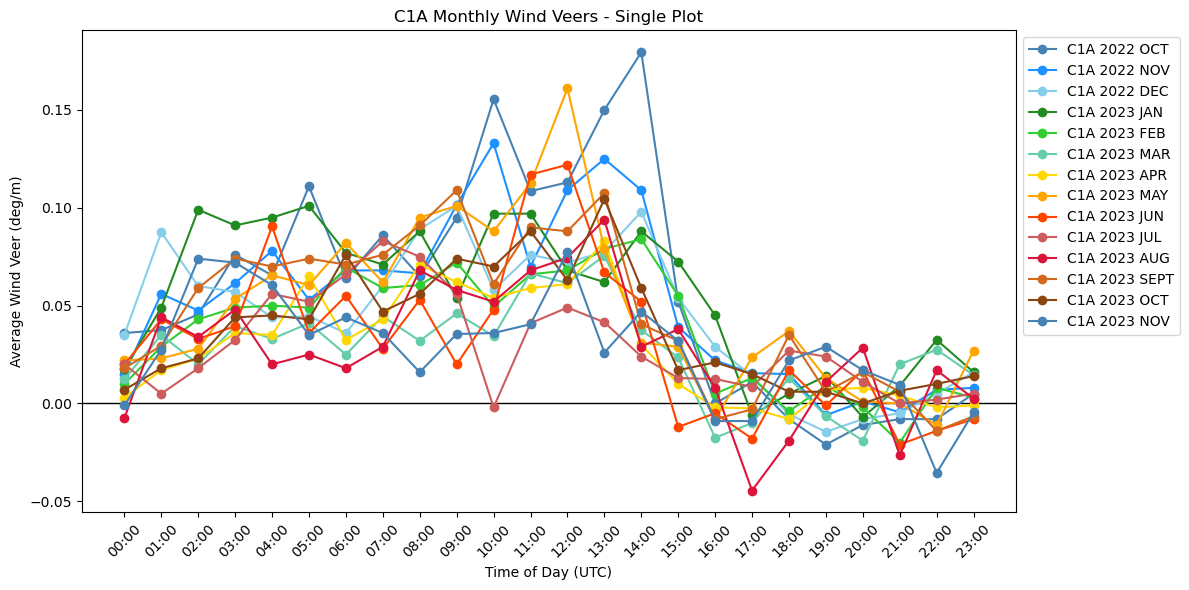

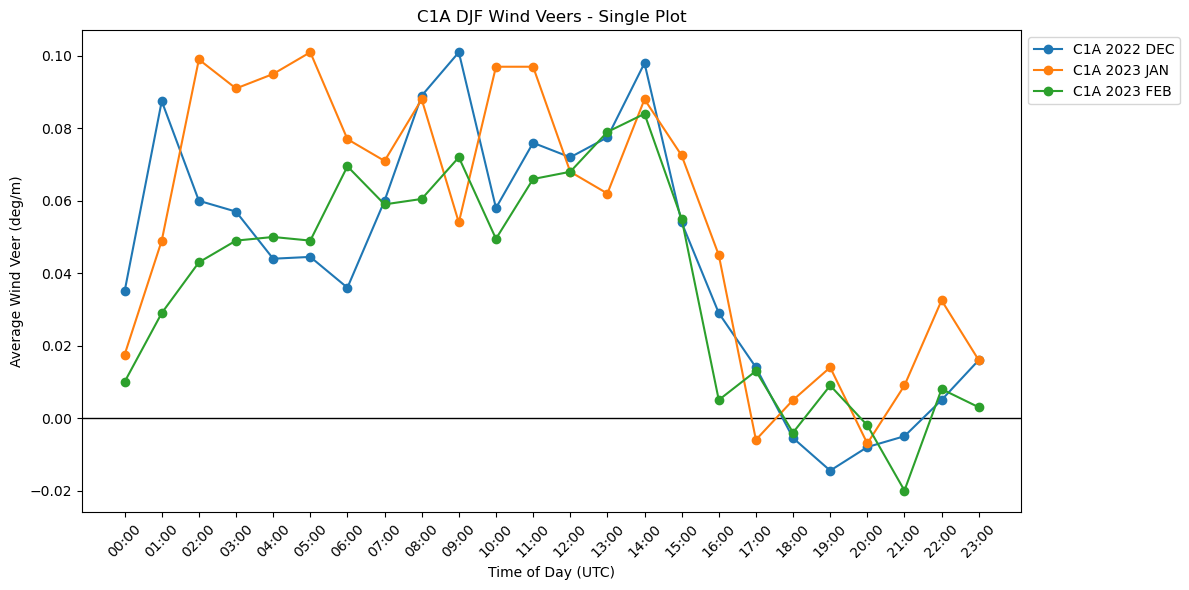

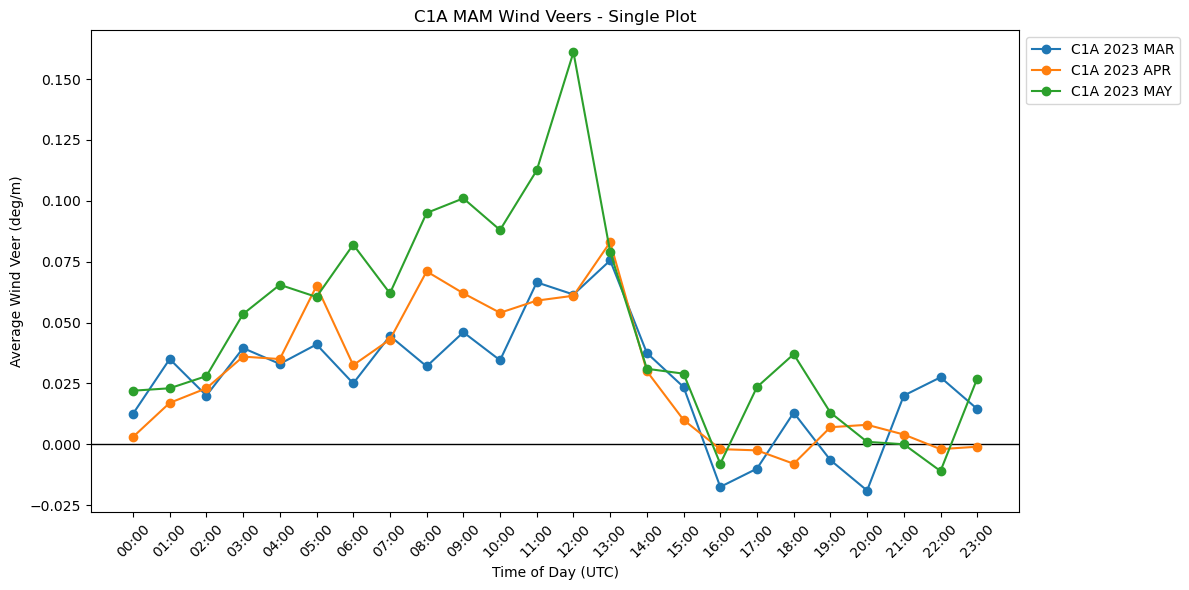

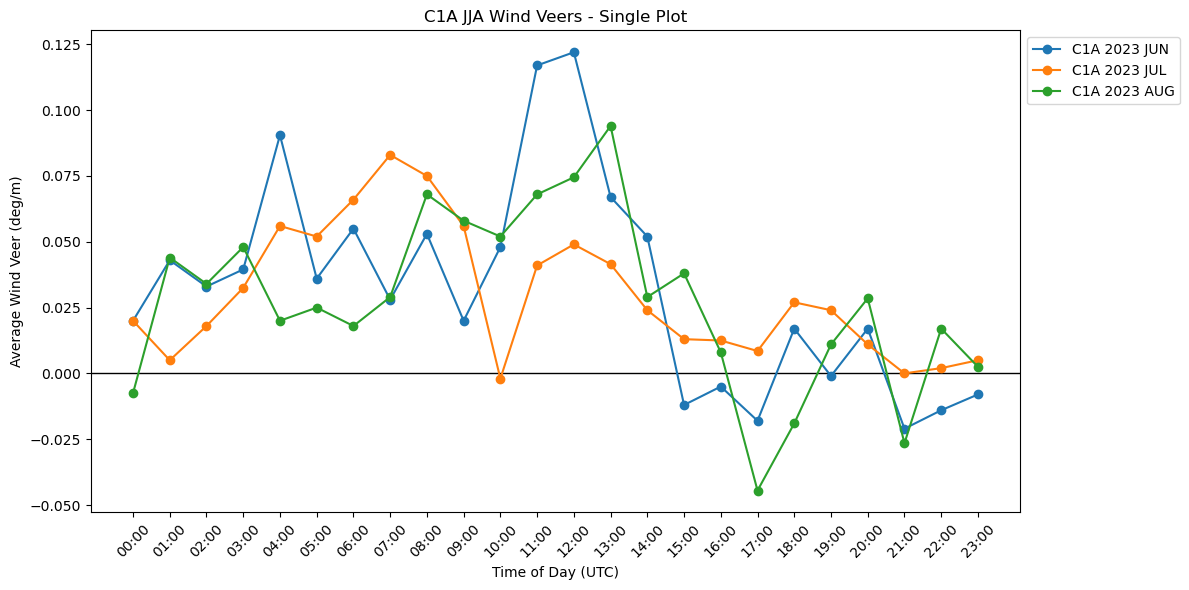

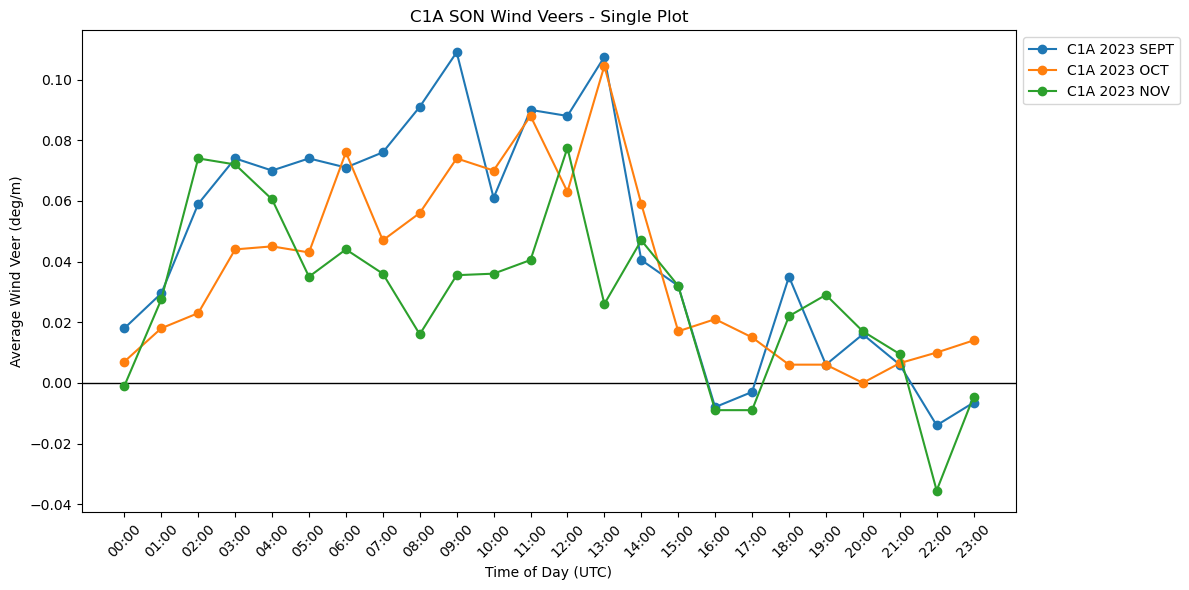

In [22]:
C1A_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A'

# Hardcoded function calls for each month with correct date ranges
C1A_202210_files = filter_files_by_date(C1A_directory, '20221001', '20221031')
C1A_times_veer_202210, C1A_wind_veer_202210 = calculate_wind_veer(C1A_202210_files)
C1A_avg_202210 = getDailyAvgWindVeer(C1A_times_veer_202210, C1A_wind_veer_202210, pd.to_datetime('2022-10-01'), pd.to_datetime('2022-10-31'))

C1A_202211_files = filter_files_by_date(C1A_directory, '20221101', '20221130')
C1A_times_veer_202211, C1A_wind_veer_202211 = calculate_wind_veer(C1A_202211_files)
C1A_avg_202211 = getDailyAvgWindVeer(C1A_times_veer_202211, C1A_wind_veer_202211, pd.to_datetime('2022-11-01'), pd.to_datetime('2022-11-30'))

C1A_202212_files = filter_files_by_date(C1A_directory, '20221201', '20221231')
C1A_times_veer_202212, C1A_wind_veer_202212 = calculate_wind_veer(C1A_202212_files)
C1A_avg_202212 = getDailyAvgWindVeer(C1A_times_veer_202212, C1A_wind_veer_202212, pd.to_datetime('2022-12-01'), pd.to_datetime('2022-12-31'))

C1A_202301_files = filter_files_by_date(C1A_directory, '20230101', '20230131')
C1A_times_veer_202301, C1A_wind_veer_202301 = calculate_wind_veer(C1A_202301_files)
C1A_avg_202301 = getDailyAvgWindVeer(C1A_times_veer_202301, C1A_wind_veer_202301, pd.to_datetime('2023-01-01'), pd.to_datetime('2023-01-31'))

C1A_202302_files = filter_files_by_date(C1A_directory, '20230201', '20230228')
C1A_times_veer_202302, C1A_wind_veer_202302 = calculate_wind_veer(C1A_202302_files)
C1A_avg_202302 = getDailyAvgWindVeer(C1A_times_veer_202302, C1A_wind_veer_202302, pd.to_datetime('2023-02-01'), pd.to_datetime('2023-02-28'))

C1A_202303_files = filter_files_by_date(C1A_directory, '20230301', '20230331')
C1A_times_veer_202303, C1A_wind_veer_202303 = calculate_wind_veer(C1A_202303_files)
C1A_avg_202303 = getDailyAvgWindVeer(C1A_times_veer_202303, C1A_wind_veer_202303, pd.to_datetime('2023-03-01'), pd.to_datetime('2023-03-31'))

C1A_202304_files = filter_files_by_date(C1A_directory, '20230401', '20230430')
C1A_times_veer_202304, C1A_wind_veer_202304 = calculate_wind_veer(C1A_202304_files)
C1A_avg_202304 = getDailyAvgWindVeer(C1A_times_veer_202304, C1A_wind_veer_202304, pd.to_datetime('2023-04-01'), pd.to_datetime('2023-04-30'))

C1A_202305_files = filter_files_by_date(C1A_directory, '20230501', '20230531')
C1A_times_veer_202305, C1A_wind_veer_202305 = calculate_wind_veer(C1A_202305_files)
C1A_avg_202305 = getDailyAvgWindVeer(C1A_times_veer_202305, C1A_wind_veer_202305, pd.to_datetime('2023-05-01'), pd.to_datetime('2023-05-31'))

C1A_202306_files = filter_files_by_date(C1A_directory, '20230601', '20230630')
C1A_times_veer_202306, C1A_wind_veer_202306 = calculate_wind_veer(C1A_202306_files)
C1A_avg_202306 = getDailyAvgWindVeer(C1A_times_veer_202306, C1A_wind_veer_202306, pd.to_datetime('2023-06-01'), pd.to_datetime('2023-06-30'))

C1A_202307_files = filter_files_by_date(C1A_directory, '20230701', '20230731')
C1A_times_veer_202307, C1A_wind_veer_202307 = calculate_wind_veer(C1A_202307_files)
C1A_avg_202307 = getDailyAvgWindVeer(C1A_times_veer_202307, C1A_wind_veer_202307, pd.to_datetime('2023-07-01'), pd.to_datetime('2023-07-31'))

C1A_202308_files = filter_files_by_date(C1A_directory, '20230801', '20230831')
C1A_times_veer_202308, C1A_wind_veer_202308 = calculate_wind_veer(C1A_202308_files)
C1A_avg_202308 = getDailyAvgWindVeer(C1A_times_veer_202308, C1A_wind_veer_202308, pd.to_datetime('2023-08-01'), pd.to_datetime('2023-08-31'))

C1A_202309_files = filter_files_by_date(C1A_directory, '20230901', '20230930')
C1A_times_veer_202309, C1A_wind_veer_202309 = calculate_wind_veer(C1A_202309_files)
C1A_avg_202309 = getDailyAvgWindVeer(C1A_times_veer_202309, C1A_wind_veer_202309, pd.to_datetime('2023-09-01'), pd.to_datetime('2023-09-30'))

C1A_202310_files = filter_files_by_date(C1A_directory, '20231001', '20231031')
C1A_times_veer_202310, C1A_wind_veer_202310 = calculate_wind_veer(C1A_202310_files)
C1A_avg_202310 = getDailyAvgWindVeer(C1A_times_veer_202310, C1A_wind_veer_202310, pd.to_datetime('2023-10-01'), pd.to_datetime('2023-10-31'))

C1A_202311_files = filter_files_by_date(C1A_directory, '20231101', '20231130')
C1A_times_veer_202311, C1A_wind_veer_202311 = calculate_wind_veer(C1A_202311_files)
C1A_avg_202311 = getDailyAvgWindVeer(C1A_times_veer_202311, C1A_wind_veer_202311, pd.to_datetime('2023-11-01'), pd.to_datetime('2023-11-30'))

C1A_dataframes = [C1A_avg_202210, C1A_avg_202211, C1A_avg_202212, C1A_avg_202301, C1A_avg_202302, C1A_avg_202303, C1A_avg_202304,
                  C1A_avg_202305, C1A_avg_202306, C1A_avg_202307, C1A_avg_202308, C1A_avg_202309, C1A_avg_202310, C1A_avg_202311]

C1A_labels = ['C1A 2022 OCT', 'C1A 2022 NOV', 'C1A 2022 DEC', 'C1A 2023 JAN', 'C1A 2023 FEB', 'C1A 2023 MAR', 'C1A 2023 APR', 
              'C1A 2023 MAY', 'C1A 2023 JUN', 'C1A 2023 JUL', 'C1A 2023 AUG', 'C1A 2023 SEPT', 'C1A 2023 OCT', 'C1A 2023 NOV'] 

plotMultipleDataFrames(C1A_dataframes, labels=C1A_labels, title="C1A Monthly Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(C1A_dataframes[2:5], labels=C1A_labels[2:5], title="C1A DJF Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(C1A_dataframes[5:8], labels=C1A_labels[5:8], title="C1A MAM Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(C1A_dataframes[8:11], labels=C1A_labels[8:11], title="C1A JJA Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(C1A_dataframes[11:], labels=C1A_labels[11:], title="C1A SON Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")

# Wind Shear C1A Layers

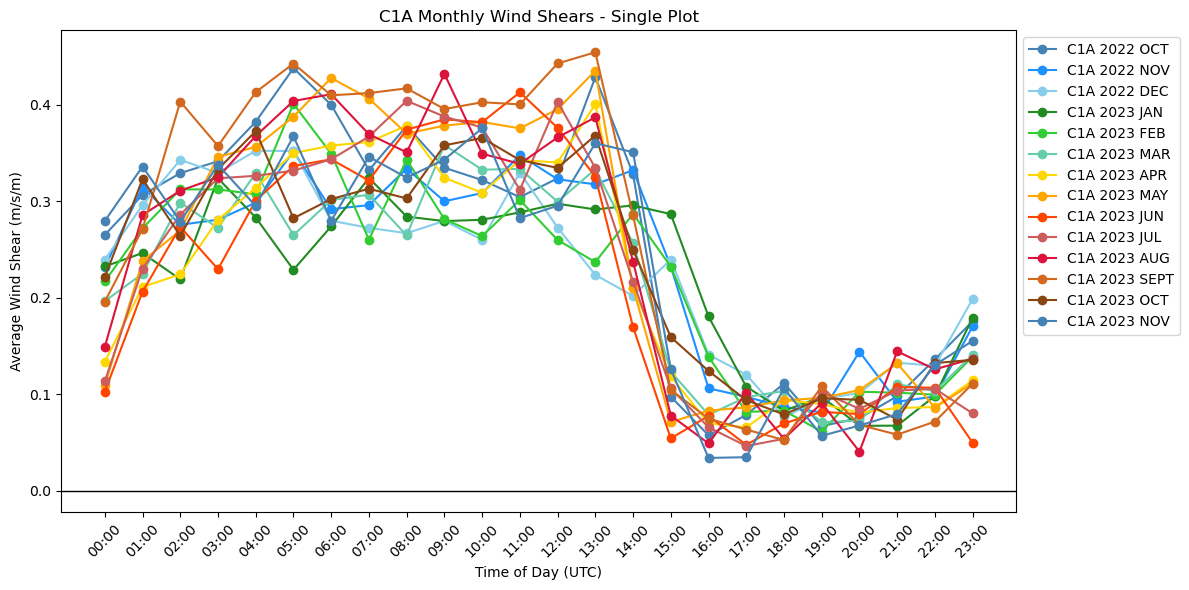

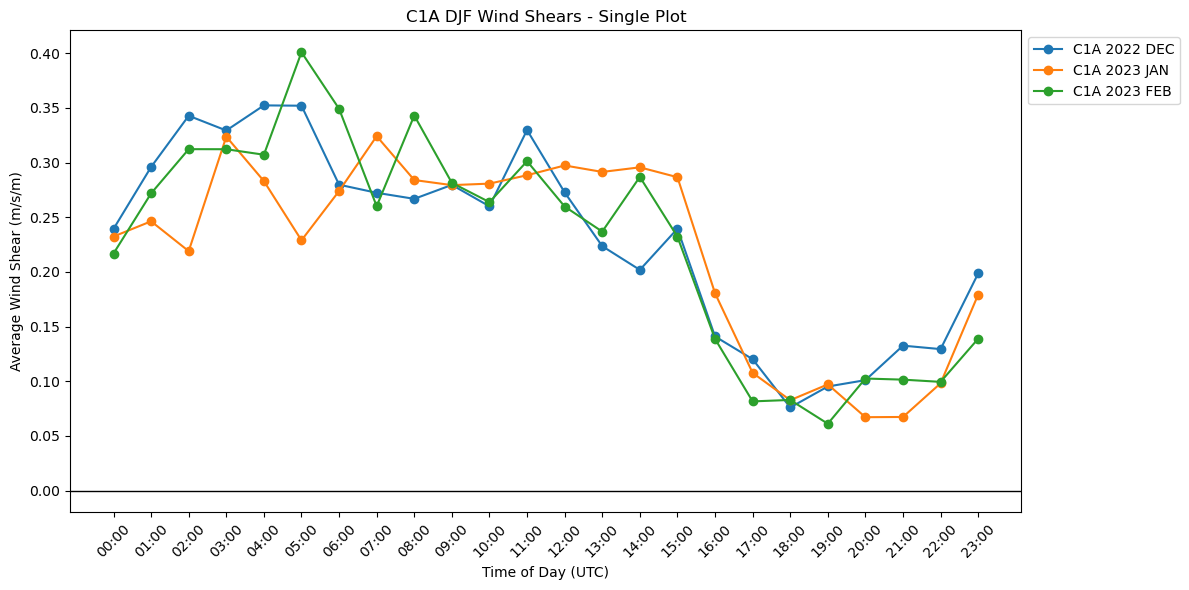

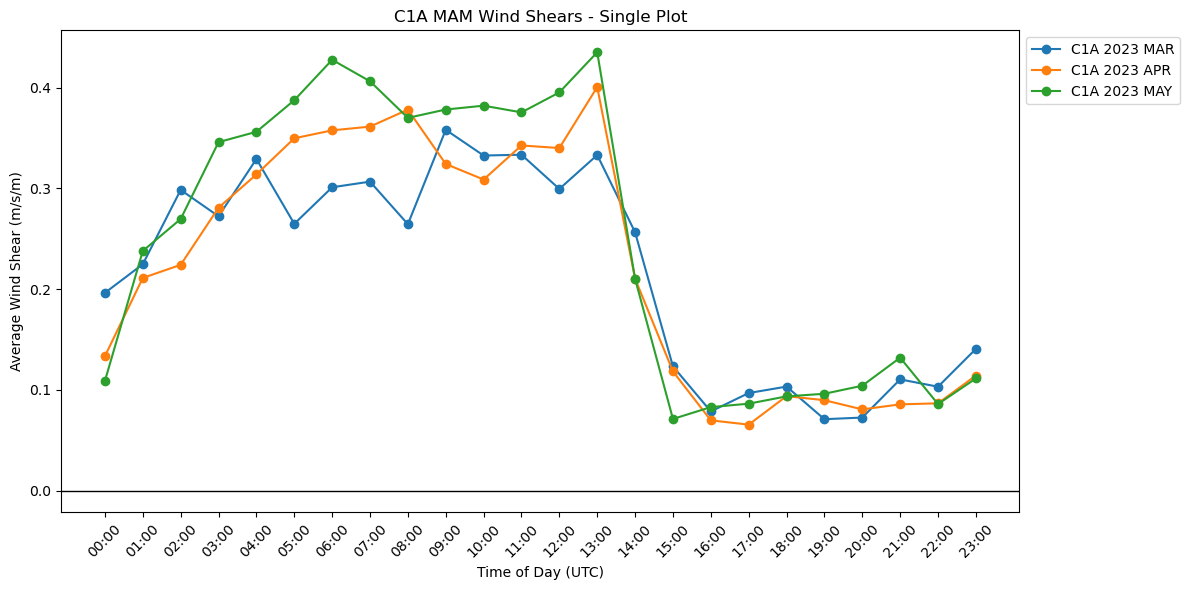

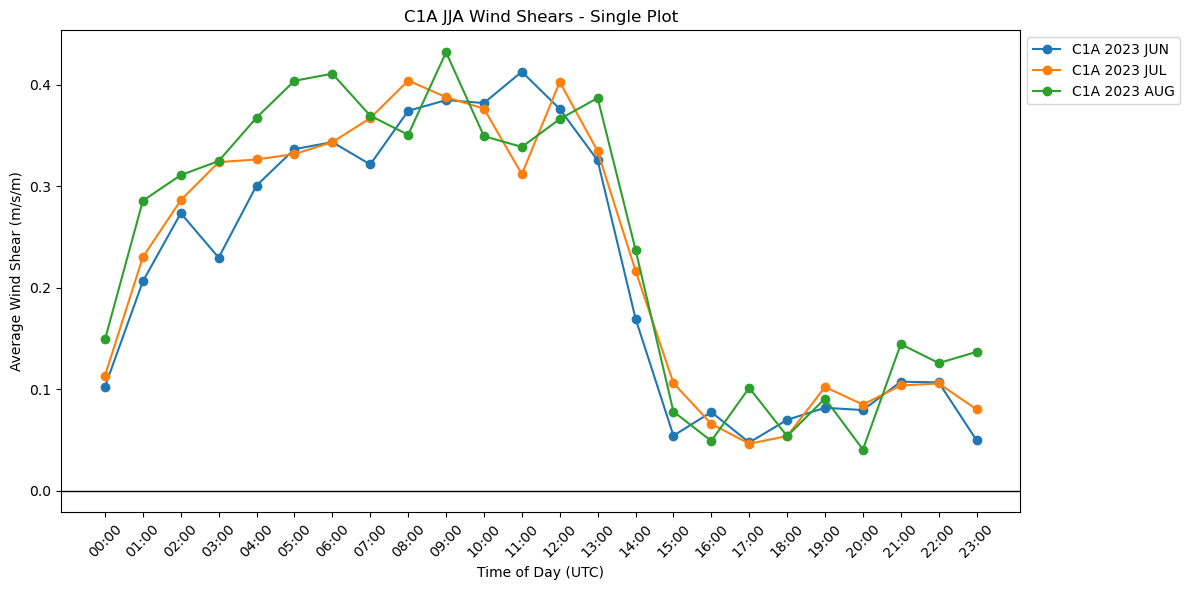

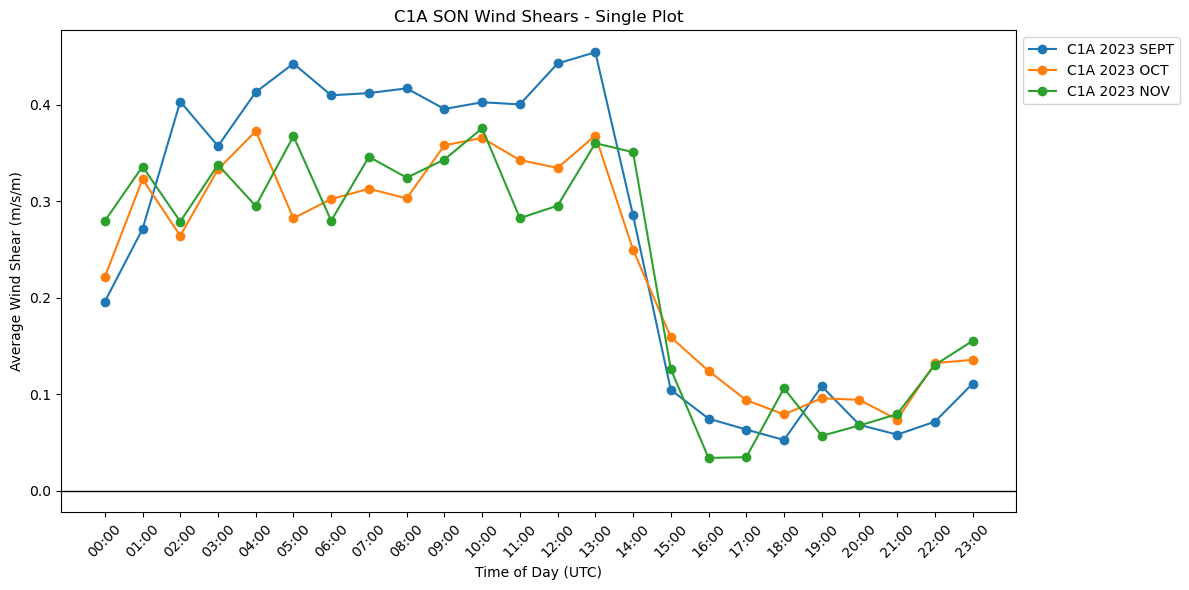

In [23]:

# Hardcoded function calls for each month with correct date ranges
C1A_times_shear_202210, C1A_wind_shear_202210 = calculate_wind_shear_with_alpha(C1A_202210_files)
C1A_avg_shear_202210 = getDailyAvgWindShear(C1A_times_shear_202210, C1A_wind_shear_202210, pd.to_datetime('2022-10-01'), pd.to_datetime('2022-10-31'))

C1A_times_shear_202211, C1A_wind_shear_202211 = calculate_wind_shear_with_alpha(C1A_202211_files)
C1A_avg_shear_202211 = getDailyAvgWindShear(C1A_times_shear_202211, C1A_wind_shear_202211, pd.to_datetime('2022-11-01'), pd.to_datetime('2022-11-30'))

C1A_times_shear_202212, C1A_wind_shear_202212 = calculate_wind_shear_with_alpha(C1A_202212_files)
C1A_avg_shear_202212 = getDailyAvgWindShear(C1A_times_shear_202212, C1A_wind_shear_202212, pd.to_datetime('2022-12-01'), pd.to_datetime('2022-12-31'))

C1A_times_shear_202301, C1A_wind_shear_202301 = calculate_wind_shear_with_alpha(C1A_202301_files)
C1A_avg_shear_202301 = getDailyAvgWindShear(C1A_times_shear_202301, C1A_wind_shear_202301, pd.to_datetime('2023-01-01'), pd.to_datetime('2023-01-31'))

C1A_times_shear_202302, C1A_wind_shear_202302 = calculate_wind_shear_with_alpha(C1A_202302_files)
C1A_avg_shear_202302 = getDailyAvgWindShear(C1A_times_shear_202302, C1A_wind_shear_202302, pd.to_datetime('2023-02-01'), pd.to_datetime('2023-02-28'))

C1A_times_shear_202303, C1A_wind_shear_202303 = calculate_wind_shear_with_alpha(C1A_202303_files)
C1A_avg_shear_202303 = getDailyAvgWindShear(C1A_times_shear_202303, C1A_wind_shear_202303, pd.to_datetime('2023-03-01'), pd.to_datetime('2023-03-31'))

C1A_times_shear_202304, C1A_wind_shear_202304 = calculate_wind_shear_with_alpha(C1A_202304_files)
C1A_avg_shear_202304 = getDailyAvgWindShear(C1A_times_shear_202304, C1A_wind_shear_202304, pd.to_datetime('2023-04-01'), pd.to_datetime('2023-04-30'))

C1A_times_shear_202305, C1A_wind_shear_202305 = calculate_wind_shear_with_alpha(C1A_202305_files)
C1A_avg_shear_202305 = getDailyAvgWindShear(C1A_times_shear_202305, C1A_wind_shear_202305, pd.to_datetime('2023-05-01'), pd.to_datetime('2023-05-31'))

C1A_times_shear_202306, C1A_wind_shear_202306 = calculate_wind_shear_with_alpha(C1A_202306_files)
C1A_avg_shear_202306 = getDailyAvgWindShear(C1A_times_shear_202306, C1A_wind_shear_202306, pd.to_datetime('2023-06-01'), pd.to_datetime('2023-06-30'))

C1A_times_shear_202307, C1A_wind_shear_202307 = calculate_wind_shear_with_alpha(C1A_202307_files)
C1A_avg_shear_202307 = getDailyAvgWindShear(C1A_times_shear_202307, C1A_wind_shear_202307, pd.to_datetime('2023-07-01'), pd.to_datetime('2023-07-31'))

C1A_times_shear_202308, C1A_wind_shear_202308 = calculate_wind_shear_with_alpha(C1A_202308_files)
C1A_avg_shear_202308 = getDailyAvgWindShear(C1A_times_shear_202308, C1A_wind_shear_202308, pd.to_datetime('2023-08-01'), pd.to_datetime('2023-08-31'))

C1A_times_shear_202309, C1A_wind_shear_202309 = calculate_wind_shear_with_alpha(C1A_202309_files)
C1A_avg_shear_202309 = getDailyAvgWindShear(C1A_times_shear_202309, C1A_wind_shear_202309, pd.to_datetime('2023-09-01'), pd.to_datetime('2023-09-30'))

C1A_times_shear_202310, C1A_wind_shear_202310 = calculate_wind_shear_with_alpha(C1A_202310_files)
C1A_avg_shear_202310 = getDailyAvgWindShear(C1A_times_shear_202310, C1A_wind_shear_202310, pd.to_datetime('2023-10-01'), pd.to_datetime('2023-10-31'))

C1A_times_shear_202311, C1A_wind_shear_202311 = calculate_wind_shear_with_alpha(C1A_202311_files)
C1A_avg_shear_202311 = getDailyAvgWindShear(C1A_times_shear_202311, C1A_wind_shear_202311, pd.to_datetime('2023-11-01'), pd.to_datetime('2023-11-30'))

C1A_dataframes = [C1A_avg_shear_202210, C1A_avg_shear_202211, C1A_avg_shear_202212, C1A_avg_shear_202301, C1A_avg_shear_202302, 
                  C1A_avg_shear_202303, C1A_avg_shear_202304, C1A_avg_shear_202305, C1A_avg_shear_202306, C1A_avg_shear_202307, 
                  C1A_avg_shear_202308, C1A_avg_shear_202309, C1A_avg_shear_202310, C1A_avg_shear_202311]

C1A_labels = ['C1A 2022 OCT', 'C1A 2022 NOV', 'C1A 2022 DEC', 'C1A 2023 JAN', 'C1A 2023 FEB', 'C1A 2023 MAR', 'C1A 2023 APR', 
              'C1A 2023 MAY', 'C1A 2023 JUN', 'C1A 2023 JUL', 'C1A 2023 AUG', 'C1A 2023 SEPT', 'C1A 2023 OCT', 'C1A 2023 NOV'] 

plotMultipleDataFrames(C1A_dataframes, labels=C1A_labels, title="C1A Monthly Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames(C1A_dataframes[2:5], labels=C1A_labels[2:5], title="C1A DJF Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames(C1A_dataframes[5:8], labels=C1A_labels[5:8], title="C1A MAM Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames(C1A_dataframes[8:11], labels=C1A_labels[8:11], title="C1A JJA Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames(C1A_dataframes[11:], labels=C1A_labels[11:], title="C1A SON Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")

# Wind Veer BLOC Layers

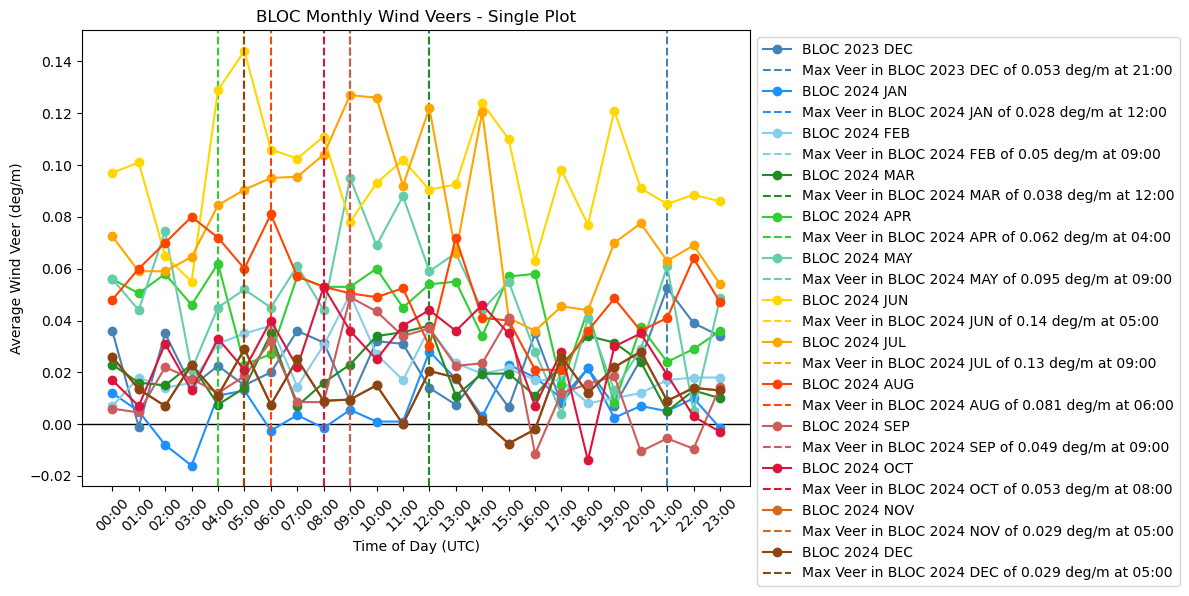

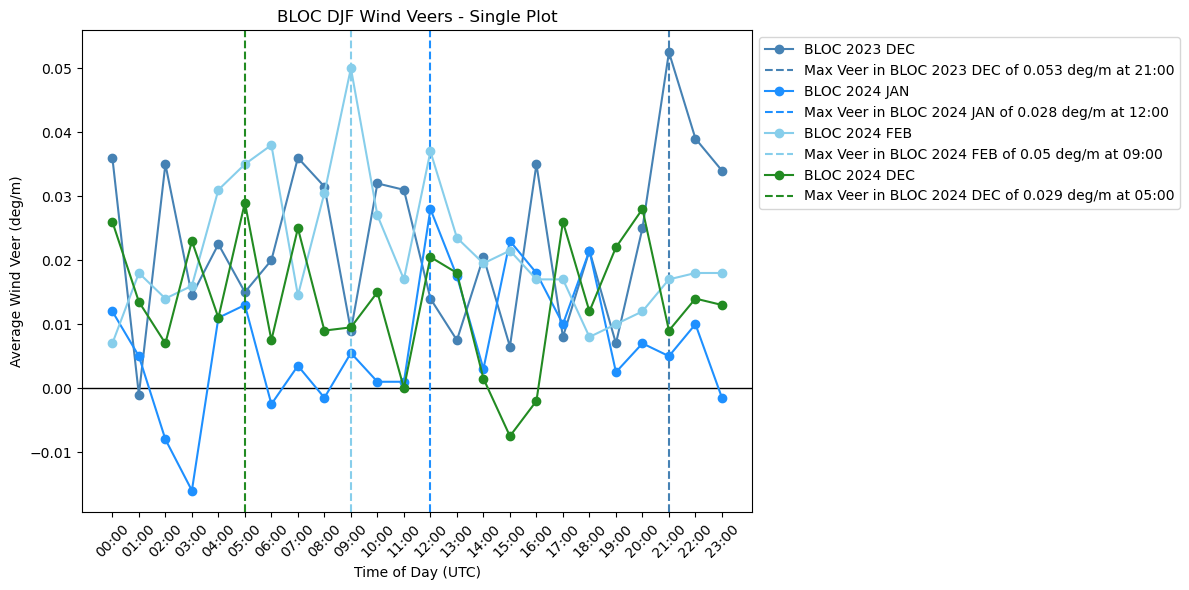

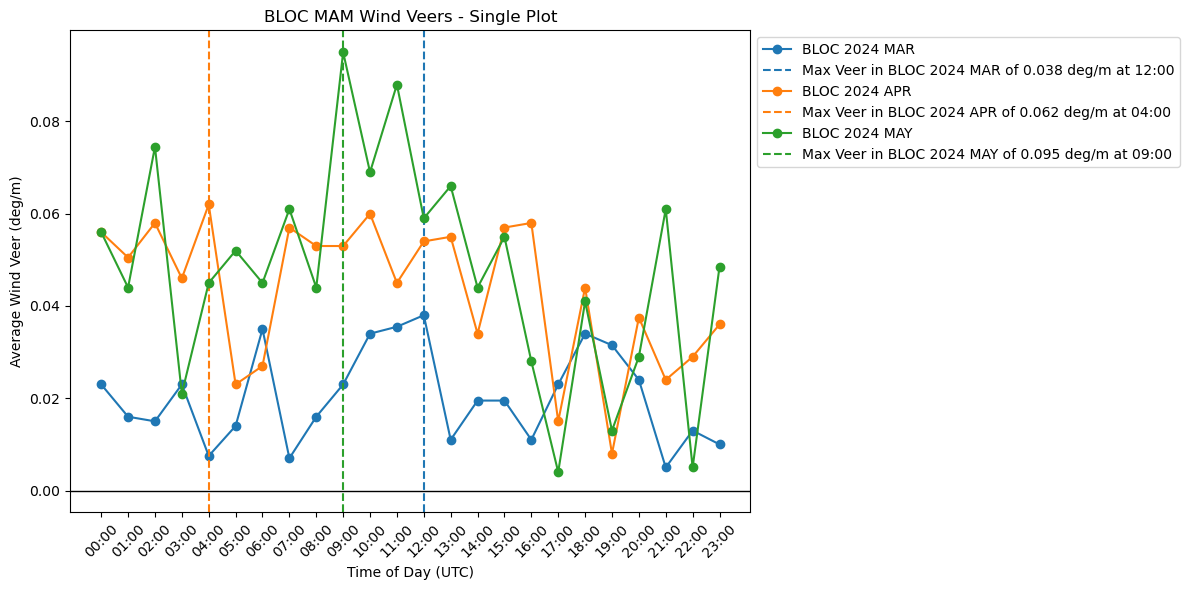

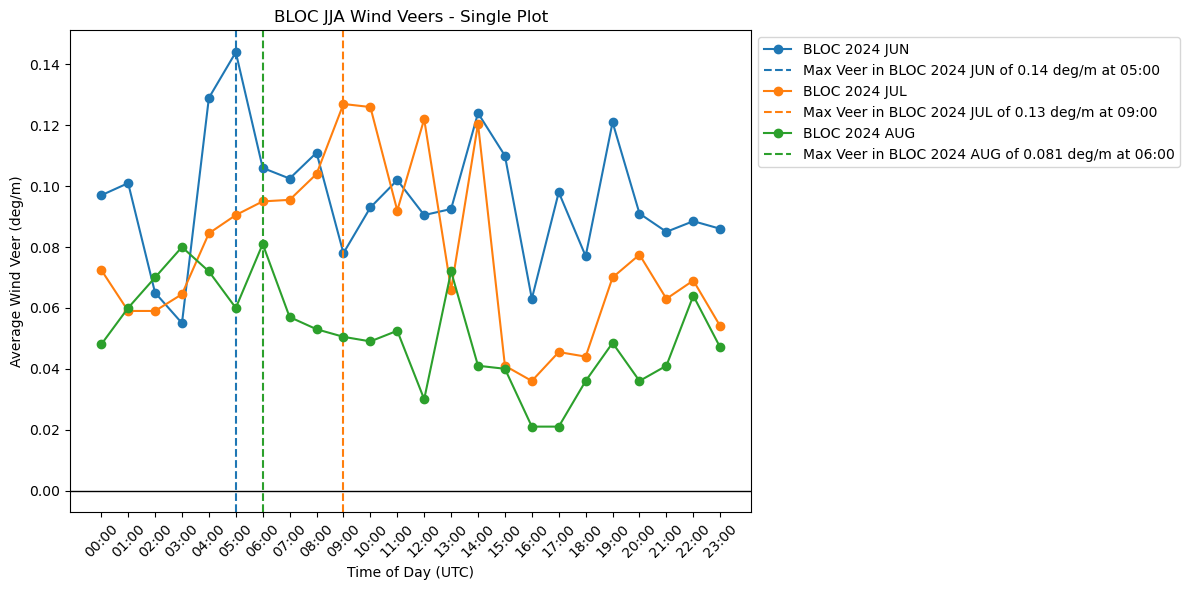

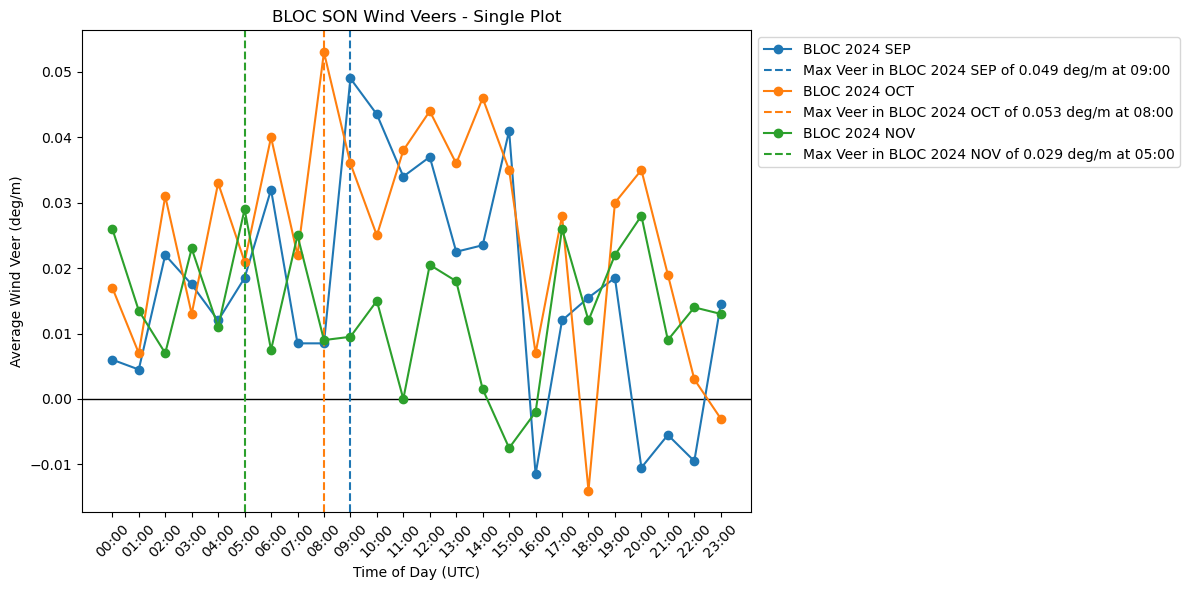

In [271]:
BLOC_directory = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_Data'  # Update with the correct directory for BLOC data

# Hardcoded function calls for each month with correct date ranges for BLOC

BLOC_202312_files = filter_files_by_date(BLOC_directory, '20231201', '20231231')
BLOC_times_veer_202312, BLOC_wind_veer_202312 = calculate_wind_veer(BLOC_202312_files)
BLOC_avg_202312 = getDailyAvgWindVeer(BLOC_times_veer_202312, BLOC_wind_veer_202312, pd.to_datetime('2023-12-01'), pd.to_datetime('2023-12-31'))

BLOC_202401_files = filter_files_by_date(BLOC_directory, '20240101', '20240131')
BLOC_times_veer_202401, BLOC_wind_veer_202401 = calculate_wind_veer(BLOC_202401_files)
BLOC_avg_202401 = getDailyAvgWindVeer(BLOC_times_veer_202401, BLOC_wind_veer_202401, pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-31'))

BLOC_202402_files = filter_files_by_date(BLOC_directory, '20240201', '20240229')  # Adjust for leap year
BLOC_times_veer_202402, BLOC_wind_veer_202402 = calculate_wind_veer(BLOC_202402_files)
BLOC_avg_202402 = getDailyAvgWindVeer(BLOC_times_veer_202402, BLOC_wind_veer_202402, pd.to_datetime('2024-02-01'), pd.to_datetime('2024-02-29'))

BLOC_202403_files = filter_files_by_date(BLOC_directory, '20240301', '20240331')
BLOC_times_veer_202403, BLOC_wind_veer_202403 = calculate_wind_veer(BLOC_202403_files)
BLOC_avg_202403 = getDailyAvgWindVeer(BLOC_times_veer_202403, BLOC_wind_veer_202403, pd.to_datetime('2024-03-01'), pd.to_datetime('2024-03-31'))

BLOC_202404_files = filter_files_by_date(BLOC_directory, '20240401', '20240430')
BLOC_times_veer_202404, BLOC_wind_veer_202404 = calculate_wind_veer(BLOC_202404_files)
BLOC_avg_202404 = getDailyAvgWindVeer(BLOC_times_veer_202404, BLOC_wind_veer_202404, pd.to_datetime('2024-04-01'), pd.to_datetime('2024-04-30'))

BLOC_202405_files = filter_files_by_date(BLOC_directory, '20240501', '20240531')
BLOC_times_veer_202405, BLOC_wind_veer_202405 = calculate_wind_veer(BLOC_202405_files)
BLOC_avg_202405 = getDailyAvgWindVeer(BLOC_times_veer_202405, BLOC_wind_veer_202405, pd.to_datetime('2024-05-01'), pd.to_datetime('2024-05-31'))

BLOC_202406_files = filter_files_by_date(BLOC_directory, '20240601', '20240630')
BLOC_times_veer_202406, BLOC_wind_veer_202406 = calculate_wind_veer(BLOC_202406_files)
BLOC_avg_202406 = getDailyAvgWindVeer(BLOC_times_veer_202406, BLOC_wind_veer_202406, pd.to_datetime('2024-06-01'), pd.to_datetime('2024-06-30'))

BLOC_202407_files = filter_files_by_date(BLOC_directory, '20240701', '20240731')
BLOC_times_veer_202407, BLOC_wind_veer_202407 = calculate_wind_veer(BLOC_202407_files)
BLOC_avg_202407 = getDailyAvgWindVeer(BLOC_times_veer_202407, BLOC_wind_veer_202407, pd.to_datetime('2024-07-01'), pd.to_datetime('2024-07-31'))

BLOC_202408_files = filter_files_by_date(BLOC_directory, '20240801', '20240831')
BLOC_times_veer_202408, BLOC_wind_veer_202408 = calculate_wind_veer(BLOC_202408_files)
BLOC_avg_202408 = getDailyAvgWindVeer(BLOC_times_veer_202408, BLOC_wind_veer_202408, pd.to_datetime('2024-08-01'), pd.to_datetime('2024-08-31'))

BLOC_202409_files = filter_files_by_date(BLOC_directory, '20240901', '20240930')
BLOC_times_veer_202409, BLOC_wind_veer_202409 = calculate_wind_veer(BLOC_202409_files)
BLOC_avg_202409 = getDailyAvgWindVeer(BLOC_times_veer_202409, BLOC_wind_veer_202409, pd.to_datetime('2024-09-01'), pd.to_datetime('2024-09-30'))

BLOC_202410_files = filter_files_by_date(BLOC_directory, '20241001', '20241031')
BLOC_times_veer_202410, BLOC_wind_veer_202410 = calculate_wind_veer(BLOC_202410_files)
BLOC_avg_202410 = getDailyAvgWindVeer(BLOC_times_veer_202410, BLOC_wind_veer_202410, pd.to_datetime('2024-10-01'), pd.to_datetime('2024-10-31'))

BLOC_202411_files = filter_files_by_date(BLOC_directory, '20241101', '20241130')
BLOC_times_veer_202411, BLOC_wind_veer_202411 = calculate_wind_veer(BLOC_202411_files)
BLOC_avg_202411 = getDailyAvgWindVeer(BLOC_times_veer_202411, BLOC_wind_veer_202411, pd.to_datetime('2024-11-01'), pd.to_datetime('2024-11-30'))

BLOC_202412_files = filter_files_by_date(BLOC_directory, '20241201', '20241231')
BLOC_times_veer_202412, BLOC_wind_veer_202412 = calculate_wind_veer(BLOC_202411_files)
BLOC_avg_202412 = getDailyAvgWindVeer(BLOC_times_veer_202412, BLOC_wind_veer_202412, pd.to_datetime('2024-12-01'), pd.to_datetime('2024-12-31'))

BLOC_dataframes = [BLOC_avg_202312, BLOC_avg_202401, BLOC_avg_202402, BLOC_avg_202403, BLOC_avg_202404, BLOC_avg_202405, BLOC_avg_202406,
                   BLOC_avg_202407, BLOC_avg_202408, BLOC_avg_202409, BLOC_avg_202410, BLOC_avg_202411, BLOC_avg_202412]

BLOC_labels = ['BLOC 2023 DEC', 'BLOC 2024 JAN', 'BLOC 2024 FEB', 'BLOC 2024 MAR', 'BLOC 2024 APR', 'BLOC 2024 MAY', 'BLOC 2024 JUN',
               'BLOC 2024 JUL', 'BLOC 2024 AUG', 'BLOC 2024 SEP', 'BLOC 2024 OCT', 'BLOC 2024 NOV', 'BLOC 2024 DEC']

plotMultipleDataFrames(BLOC_dataframes, labels=BLOC_labels, title="BLOC Monthly Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(BLOC_dataframes[:3] + [BLOC_dataframes[-1]], labels=BLOC_labels[:3] + [BLOC_labels[-1]], title="BLOC DJF Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(BLOC_dataframes[3:6], labels=BLOC_labels[3:6], title="BLOC MAM Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(BLOC_dataframes[6:9], labels=BLOC_labels[6:9], title="BLOC JJA Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")
plotMultipleDataFrames(BLOC_dataframes[9:12], labels=BLOC_labels[9:12], title="BLOC SON Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Veer (deg/m)")


# Wind Shear BLOC Layers

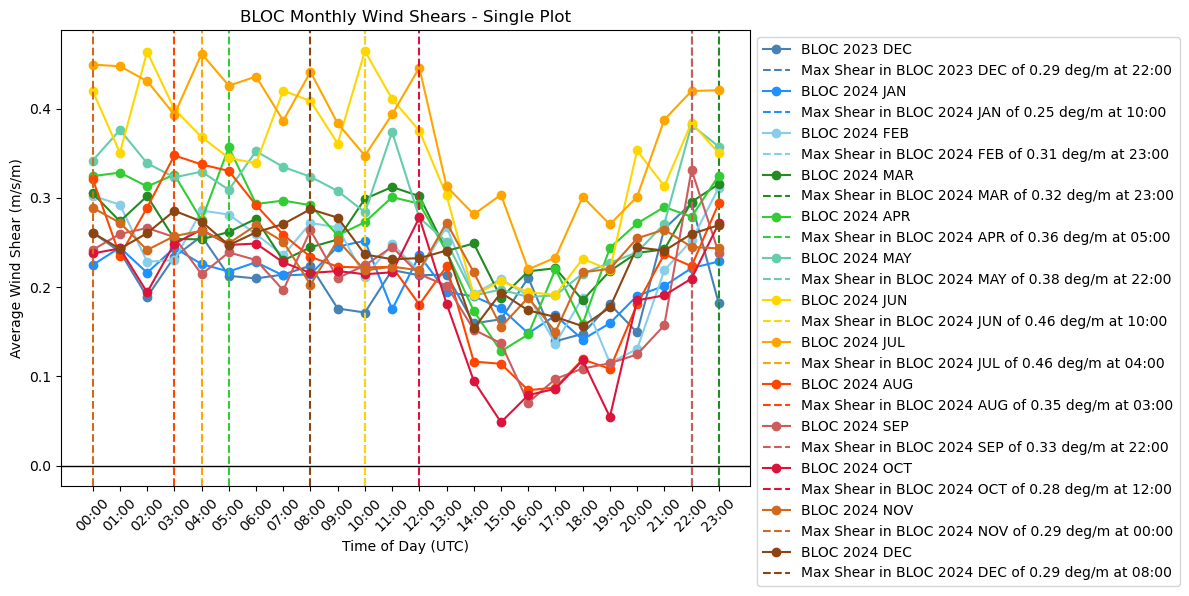

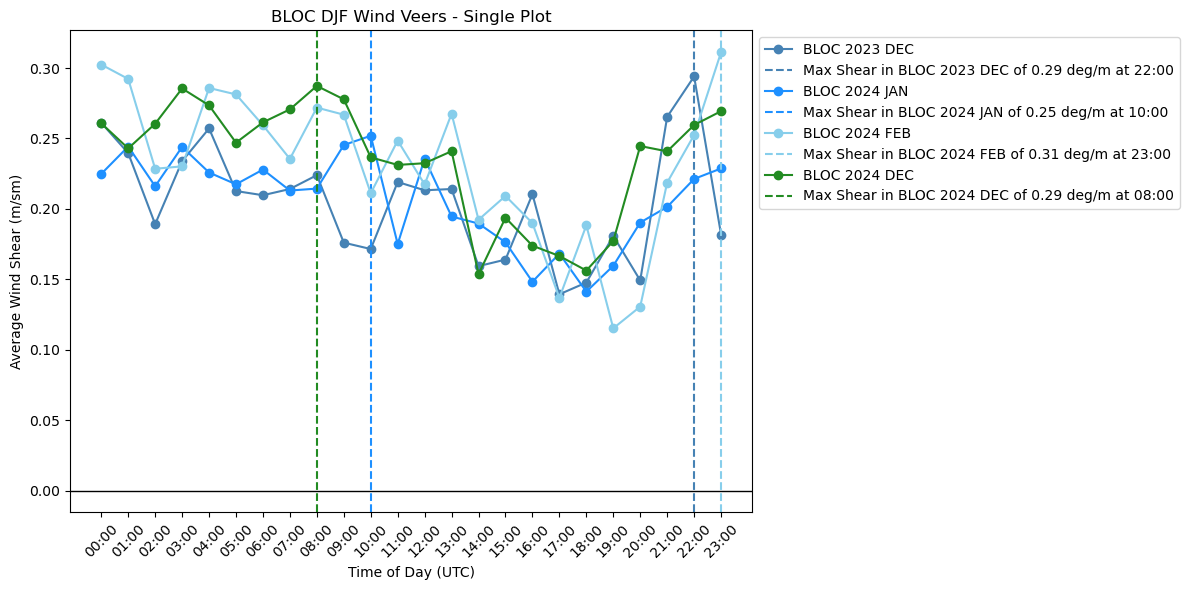

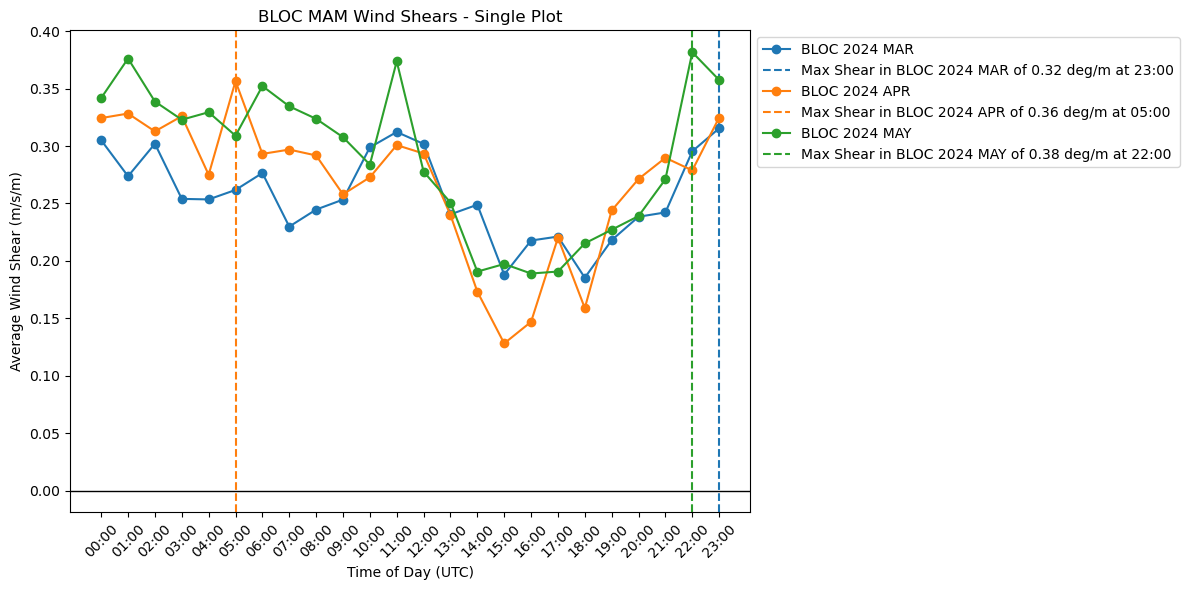

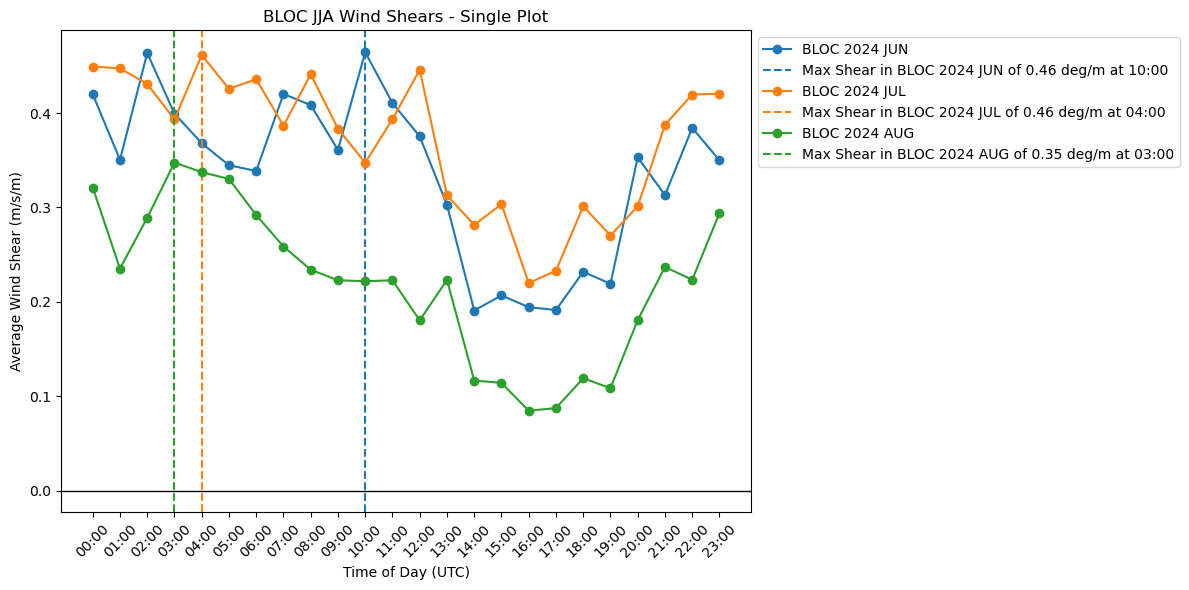

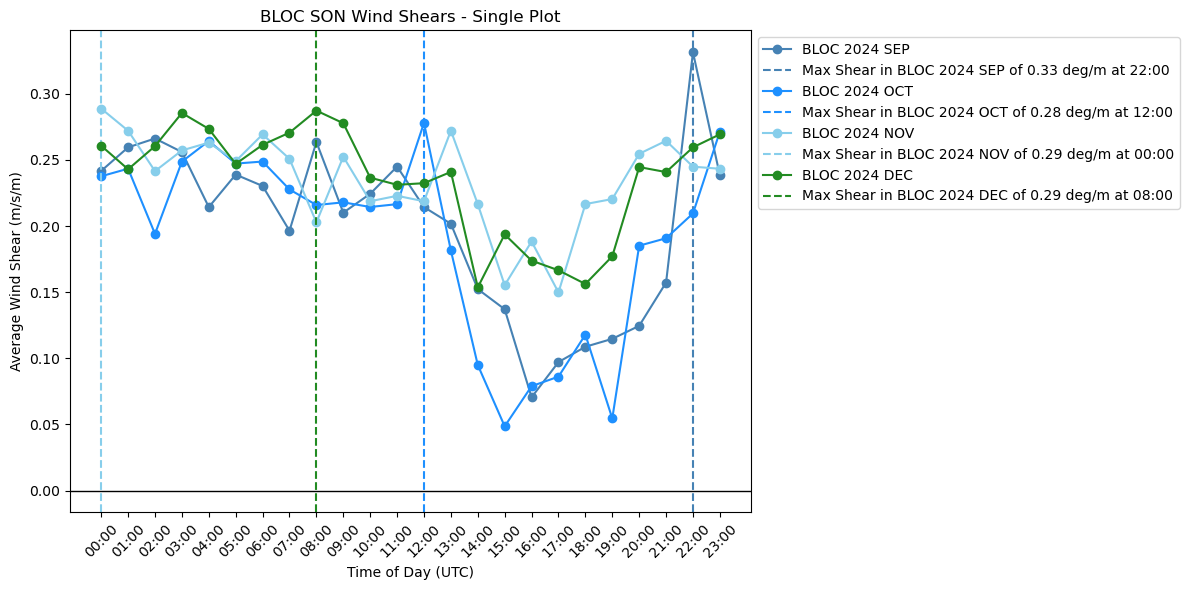

In [273]:
BLOC_times_shear_202312, BLOC_wind_shear_202312 = calculate_wind_shear_with_alpha(BLOC_202312_files)
BLOC_avg_shear_202312 = getDailyAvgWindShear(BLOC_times_shear_202312, BLOC_wind_shear_202312, pd.to_datetime('2023-12-01'), pd.to_datetime('2023-12-31'))

BLOC_times_shear_202401, BLOC_wind_shear_202401 = calculate_wind_shear_with_alpha(BLOC_202401_files)
BLOC_avg_shear_202401 = getDailyAvgWindShear(BLOC_times_shear_202401, BLOC_wind_shear_202401, pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-31'))

BLOC_times_shear_202402, BLOC_wind_shear_202402 = calculate_wind_shear_with_alpha(BLOC_202402_files)
BLOC_avg_shear_202402 = getDailyAvgWindShear(BLOC_times_shear_202402, BLOC_wind_shear_202402, pd.to_datetime('2024-02-01'), pd.to_datetime('2024-02-29'))

BLOC_times_shear_202403, BLOC_wind_shear_202403 = calculate_wind_shear_with_alpha(BLOC_202403_files)
BLOC_avg_shear_202403 = getDailyAvgWindShear(BLOC_times_shear_202403, BLOC_wind_shear_202403, pd.to_datetime('2024-03-01'), pd.to_datetime('2024-03-31'))

BLOC_times_shear_202404, BLOC_wind_shear_202404 = calculate_wind_shear_with_alpha(BLOC_202404_files)
BLOC_avg_shear_202404 = getDailyAvgWindShear(BLOC_times_shear_202404, BLOC_wind_shear_202404, pd.to_datetime('2024-04-01'), pd.to_datetime('2024-04-30'))

BLOC_times_shear_202405, BLOC_wind_shear_202405 = calculate_wind_shear_with_alpha(BLOC_202405_files)
BLOC_avg_shear_202405 = getDailyAvgWindShear(BLOC_times_shear_202405, BLOC_wind_shear_202405, pd.to_datetime('2024-05-01'), pd.to_datetime('2024-05-31'))

BLOC_times_shear_202406, BLOC_wind_shear_202406 = calculate_wind_shear_with_alpha(BLOC_202406_files)
BLOC_avg_shear_202406 = getDailyAvgWindShear(BLOC_times_shear_202406, BLOC_wind_shear_202406, pd.to_datetime('2024-06-01'), pd.to_datetime('2024-06-30'))

BLOC_times_shear_202407, BLOC_wind_shear_202407 = calculate_wind_shear_with_alpha(BLOC_202407_files)
BLOC_avg_shear_202407 = getDailyAvgWindShear(BLOC_times_shear_202407, BLOC_wind_shear_202407, pd.to_datetime('2024-07-01'), pd.to_datetime('2024-07-31'))

BLOC_times_shear_202408, BLOC_wind_shear_202408 = calculate_wind_shear_with_alpha(BLOC_202408_files)
BLOC_avg_shear_202408 = getDailyAvgWindShear(BLOC_times_shear_202408, BLOC_wind_shear_202408, pd.to_datetime('2024-08-01'), pd.to_datetime('2024-08-31'))

BLOC_times_shear_202409, BLOC_wind_shear_202409 = calculate_wind_shear_with_alpha(BLOC_202409_files)
BLOC_avg_shear_202409 = getDailyAvgWindShear(BLOC_times_shear_202409, BLOC_wind_shear_202409, pd.to_datetime('2024-09-01'), pd.to_datetime('2024-09-30'))

BLOC_times_shear_202410, BLOC_wind_shear_202410 = calculate_wind_shear_with_alpha(BLOC_202410_files)
BLOC_avg_shear_202410 = getDailyAvgWindShear(BLOC_times_shear_202410, BLOC_wind_shear_202410, pd.to_datetime('2024-10-01'), pd.to_datetime('2024-10-31'))

BLOC_times_shear_202411, BLOC_wind_shear_202411 = calculate_wind_shear_with_alpha(BLOC_202411_files)
BLOC_avg_shear_202411 = getDailyAvgWindShear(BLOC_times_shear_202411, BLOC_wind_shear_202411, pd.to_datetime('2024-11-01'), pd.to_datetime('2024-11-30'))

BLOC_times_shear_202412, BLOC_wind_shear_202412 = calculate_wind_shear_with_alpha(BLOC_202412_files)
BLOC_avg_shear_202412 = getDailyAvgWindShear(BLOC_times_shear_202412, BLOC_wind_shear_202412, pd.to_datetime('2024-12-01'), pd.to_datetime('2024-12-31'))


BLOC_dataframes = [BLOC_avg_shear_202312, BLOC_avg_shear_202401, BLOC_avg_shear_202402, BLOC_avg_shear_202403, 
                   BLOC_avg_shear_202404, BLOC_avg_shear_202405, BLOC_avg_shear_202406, BLOC_avg_shear_202407, 
                   BLOC_avg_shear_202408, BLOC_avg_shear_202409, BLOC_avg_shear_202410, BLOC_avg_shear_202411, BLOC_avg_shear_202412]

BLOC_labels = ['BLOC 2023 DEC', 'BLOC 2024 JAN', 'BLOC 2024 FEB', 'BLOC 2024 MAR', 'BLOC 2024 APR', 'BLOC 2024 MAY', 'BLOC 2024 JUN',
               'BLOC 2024 JUL', 'BLOC 2024 AUG', 'BLOC 2024 SEP', 'BLOC 2024 OCT', 'BLOC 2024 NOV', 'BLOC 2024 DEC']

plotMultipleDataFrames(BLOC_dataframes, labels=BLOC_labels, title="BLOC Monthly Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames(BLOC_dataframes[:3] + [BLOC_dataframes[-1]], labels=BLOC_labels[:3] + [BLOC_labels[-1]], title="BLOC DJF Wind Veers - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/sm)")
plotMultipleDataFrames(BLOC_dataframes[3:6], labels=BLOC_labels[3:6], title="BLOC MAM Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames(BLOC_dataframes[6:9], labels=BLOC_labels[6:9], title="BLOC JJA Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
plotMultipleDataFrames(BLOC_dataframes[9:], labels=BLOC_labels[9:], title="BLOC SON Wind Shears - Single Plot", xlabel="Time of Day (UTC)", ylabel="Average Wind Shear (m/s/m)")
